# Classification of Alzhaimer through Brain MRI

## Importing Libraries

In [1]:
#Package imports.
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import random
import tensorflow as tf
from keras.utils import to_categorical
from keras import layers,models,losses
from sklearn import model_selection, metrics, preprocessing
from skimage.metrics import structural_similarity as ssim

In [2]:
#Import and mount Google Drive.
from google.colab import drive
#
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Images

In [3]:
#Unzip the dataset file and store it in a folder called images.
#!unzip "/content/drive/MyDrive/MRI.zip" -d "/content/drive/MyDrive/images_MRI/"

In [4]:
!ls "/content/drive/MyDrive/images_MRI/Data"

'Mild Dementia'  'Moderate Dementia'  'Non Demented'  'Very mild Dementia'


In [5]:
#Read the images and get the data in a RGB and specific shape
folder_path = "/content/drive/MyDrive/images_MRI/Data/"
size = 128
data = []
labels = []
paths=[]
for folder in os.listdir(folder_path):
    for files in os.listdir(os.path.join(folder_path, folder)):
        if files.endswith("jpg"):
            labels.append(folder)
            #Create the image path.
            img_path = os.path.join(folder_path, folder, files)
            #Read in the images.
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            #Change BGR colour default from cv2 to RGB used in matplotlib.
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #Resize the images.
            img = cv2.resize(img, (size, size))
            data.append(img)
            paths.append(img_path)

#Convert the data from a list to a NumPy array.
data_arr = np.array(data)

## Select by random sampling

In [6]:
#labels_np=np.array(labels)
#selected_indices={}
#for t in ['Mild Dementia','Non Demented','Very mild Dementia']:
#  selected_indices[t]=np.random.choice(np.where(labels_np==t)[0],500,replace=False)
#all_indices=np.hstack((selected_indices['Mild Dementia'],selected_indices['Non Demented'],selected_indices['Very mild Dementia'],np.where(labels_np=='Moderate Dementia')[0]))
#paths_to_delete=np.setdiff1d(np.array(paths),np.array(paths)[all_indices])
#for n in paths_to_delete:
#  os.remove(n)

## Data Analysis

In [7]:
#Check the size of the images
data_arr.shape

(1988, 128, 128, 3)

In [8]:
#Check all the classes
set(labels)

{'Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia'}

In [9]:
#Checking number of images from Mild Dementia
print('Mild Dementia:',labels.count("Mild Dementia"))
#Checking number of images from Moderate Dementia
print('Moderate Dementia:',labels.count("Moderate Dementia"))
#Checking number of images from Non Demented
print('Non Demented:',labels.count("Non Demented"))
#Checking number of images from Very mild Dementia
print('Very mild Dementia:',labels.count("Very mild Dementia"))

Mild Dementia: 500
Moderate Dementia: 488
Non Demented: 500
Very mild Dementia: 500


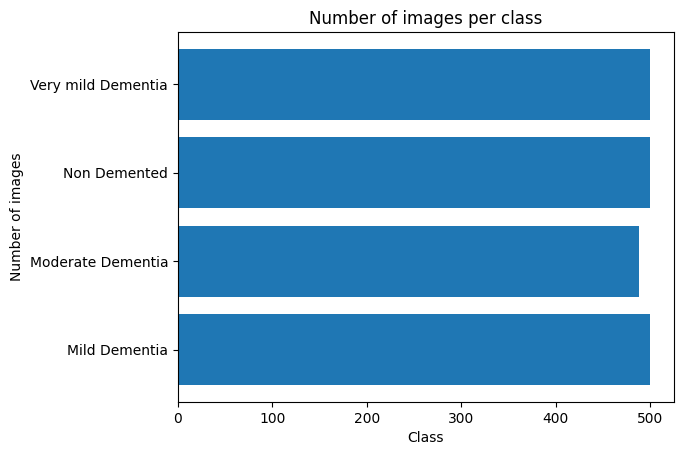

In [10]:
#Plotting horizontal barchart of the classes and images.
labels_plt=['Mild Dementia','Moderate Dementia','Non Demented','Very mild Dementia']
count=[labels.count('Mild Dementia'),labels.count('Moderate Dementia'),labels.count('Non Demented'),labels.count('Very mild Dementia')]
fig,ax=plt.subplots()
ax.barh(labels_plt,count)
ax.set_title('Number of images per class')
ax.set_xlabel('Class')
ax.set_ylabel('Number of images')
plt.show()

(-0.5, 127.5, 127.5, -0.5)

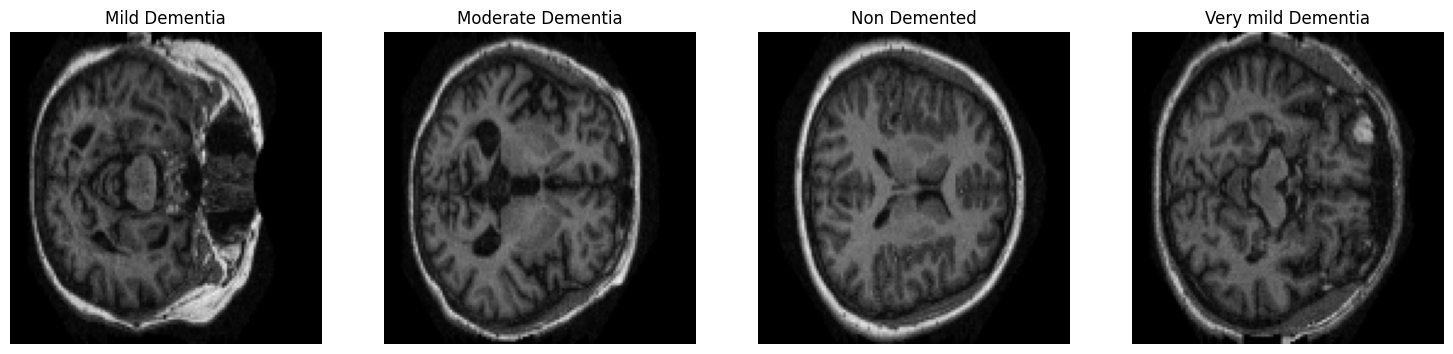

In [11]:
#Plot of examples by class of image
fig,ax=plt.subplots(1,4)
fig.set_size_inches(18.5, 10.5)
ax[0].imshow(data_arr[np.random.choice(range(1,500),1)[0]])
ax[0].set_title('Mild Dementia')
ax[0].axis('off')
ax[1].imshow(data_arr[np.random.choice(range(501,1000),1)[0]])
ax[1].set_title('Moderate Dementia')
ax[1].axis('off')
ax[2].imshow(data_arr[np.random.choice(range(1001,1500),1)[0]])
ax[2].set_title('Non Demented')
ax[2].axis('off')
ax[3].imshow(data_arr[np.random.choice(range(1501,1993),1)[0]])
ax[3].set_title('Very mild Dementia')
ax[3].axis('off')

## Preprocessing

### Create noise and data augmentation

In [12]:
#Function for create noise in the image.
def image_noise(image, noise_level):
    image = tf.cast(image, tf.int32)
    height, width, channels = image.shape[0], image.shape[1], image.shape[2]
    pixels_total = height * width * channels
    noise_added = pixels_total * noise_level
    noise_total=0
    #Get the percentage of noise
    while noise_total<noise_added:
      w=random.randint(1,3)
      h=random.randint(1,3)
      x=random.randint(1,width-w)
      y=random.randint(1,height-h)
      noise_total += w*h
      noise_to_add=w*h*3
      #Create the indices for introduce noise
      indices = [[j, k, i] for i in range(3) for j
                 in range(y, y + h) for k in range(x, x + w)]
      #Generate black noise
      noise_values = [np.random.randint(1,25)]*noise_to_add
      #Introduce noise
      image = tf.tensor_scatter_nd_update(image, indices, noise_values)
    return image

In [13]:

#Function for create noise in the image.
#def image_noise(image,noise_level):
#  height, width, channels = image.shape
#  pixels_total=height*width*channels
#  noise_added=int(pixels_total*noise_level)
#  noise_total=0
#  while noise_total<noise_added:
#    w=random.randint(1,3)
#    h=random.randint(1,3)
#    noise_total+=w*h
#    x=random.randint(0,width-w)
#    y=random.randint(0,height-h)
#    image[y:y+h,x:x+w,:]=np.random.randint(1,25)
#  return image

In [14]:
#Function for augment the images
def image_augment(image,seed):
    new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
    #Random left flip
    image = tf.image.stateless_random_flip_left_right(
       image, seed)
    #Random brightness change
    #image = tf.image.stateless_random_brightness(
       # image, max_delta=0.1, seed=new_seed)
    #Introduce hue
    #image = tf.image.stateless_random_hue(
       # image, 0.2, seed)
    #Introduce saturation
    #image = tf.image.stateless_random_saturation(
        #image, 0.3, 1.0, seed)
    #Adjust any value to the RGB range
    image = tf.clip_by_value(image, 0, 255)
    return image

In [15]:
#Set the random seed generator
rng = tf.random.Generator.from_seed(123, alg='philox')

In [16]:
#Function to prepare the images with noise and augmentation
def image_wrapper(image):
  #Generate random independent seed
  seed=rng.make_seeds(2)[0]
  #Augment data with the random seed
  image1=image_augment(image,seed)
  #Add noise
  image2=image_noise(image1,0.1)
  return image2/255,image1/255

In [17]:

def mse(image1,image2):
  mse=np.mean((image1.astype('float')-image2.astype('float'))**2)
  return mse

In [18]:

def psnr(mse):
  psnr=20*np.log10(255/np.sqrt(mse))
  return psnr

In [80]:
def ssim_mean(image1,image2):
  ssim_values=[]
  for n in range(0,image1.shape[0]):
      ssim_value = ssim(image1[n],image2[n],channel_axis=2,data_range=image1[n].max()-image1[n].min())
      ssim_values.append(ssim_value)
  ssim_mean = np.mean(ssim_values)
  return ssim_mean

In [20]:
#Get dataset tensorflow type
data=tf.data.Dataset.from_tensor_slices(data_arr)

In [21]:
#Split train and test
data_train,data_test=model_selection.train_test_split(data_arr, test_size=0.2, random_state=42)
data_train,data_validation=model_selection.train_test_split(data_train, test_size=0.2, random_state=42)

In [22]:
#Preprocess the data
data_train_processed=tf.data.Dataset.from_tensor_slices(data_train).shuffle(100).map(image_wrapper).batch(32)
data_test_processed=tf.data.Dataset.from_tensor_slices(data_test).shuffle(100).map(image_wrapper).batch(32)
data_validation_processed=tf.data.Dataset.from_tensor_slices(data_validation).shuffle(100).map(image_wrapper).batch(32)

In [23]:
#Get data preprocessed
data_test_processed

<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None))>

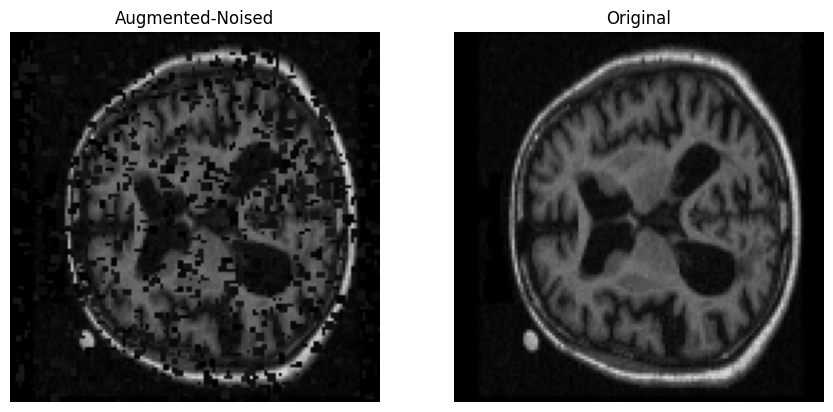

In [24]:
#Examples of
for item in data_train_processed.take(1):
    fig,ax=plt.subplots(1,2)
    fig.set_size_inches(10.5, 7.5)
    ax[0].imshow(item[0][0].numpy())
    ax[0].set_title('Augmented-Noised')
    ax[0].axis('off')
    ax[1].imshow(item[1][0].numpy())
    ax[1].set_title('Original')
    ax[1].axis('off')

In [25]:
test_original = np.asarray(list(data_test_processed.unbatch().map(lambda x, y: y)))

## Denoising

In [26]:
single_test_original=np.expand_dims(data_arr[1]/255,axis=0)
single_test_noise=np.expand_dims(image_noise(data_arr[1],0.07).numpy()/255,axis=0)

### Autoencoder

In [27]:
#Basic auto encoder for denoising
#Encoder 1Conv + BatchNorm + MaxPooling
def encoder(filters):
    def apply(x):
        x=layers.Conv2D(filters, (3,3), padding='same', activation='relu')(x)
        x=layers.BatchNormalization()(x)
        x=layers.MaxPooling2D((2,2),padding='same')(x)
        return x
    return apply

In [28]:
#Decoder 1ConvTrans + BatchNorm
def decoder(filters):
    def apply(x):
        x=layers.Conv2DTranspose(filters, (3,3), strides=2, padding='same', activation='relu')(x)
        x=layers.BatchNormalization()(x)
        return x
    return apply

In [29]:
#Auto Encoder 3Encoder + 3Decoder from 3 to 128
def autoencoder(input_shape=(128, 128, 3)):
    inputs=layers.Input(shape=input_shape)
    #Encoder
    x=encoder(32)(inputs)
    x=encoder(64)(x)
    x=encoder(128)(x)
    #Decoder
    x=decoder(128)(x)
    x=decoder(64)(x)
    x=decoder(32)(x)
    outputs=layers.Conv2D(3, (1,1), activation='sigmoid')(x)
    return models.Model(inputs, outputs)

In [30]:
#Define autoencoder and see the structure
ae=autoencoder()
ae.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 128, 128, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 3)         │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 334,979 (1.28 MB)

 Trainable params: 334,083 (1.27 MB)

 Non-trainable params: 896 (3.50 KB)

In [31]:
#Compile model with adam and mean squared error
ae.compile(optimizer='adam',loss='mse')

In [32]:
ae_history=ae.fit(data_train_processed,epochs=10,validation_data=data_validation_processed)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 133s 3s/step - loss: 0.1145 - val_loss: 0.0744
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - loss: 0.0526 - val_loss: 0.0368
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step - loss: 0.0318 - val_loss: 0.0303
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - loss: 0.0203 - val_loss: 0.0323
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step - loss: 0.0129 - val_loss: 0.0347
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - loss: 0.0086 - val_loss: 0.0340
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - loss: 0.0065 - val_loss: 0.0317
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - loss: 0.0053 - val_loss: 0.0268
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 106s 3s/step - loss: 0.0046 - val_loss: 0.0212
Epoch 10/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - loss: 0.0042 - val_loss: 0.0164


In [33]:
ae_prediction=ae.predict(single_test_noise)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


(-0.5, 127.5, 127.5, -0.5)

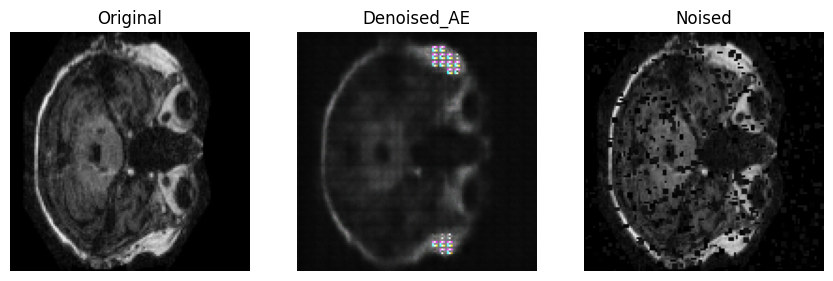

In [34]:
fig,ax=plt.subplots(1,3)
fig.set_size_inches(10.5, 7.5)
#fig.suptitle('Auto Encoder denoising',fontsize=16)
ax[0].imshow(single_test_original[0])
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(ae_prediction[0])
ax[1].set_title('Denoised_AE')
ax[1].axis('off')
ax[2].imshow(single_test_noise[0])
ax[2].set_title('Noised')
ax[2].axis('off')

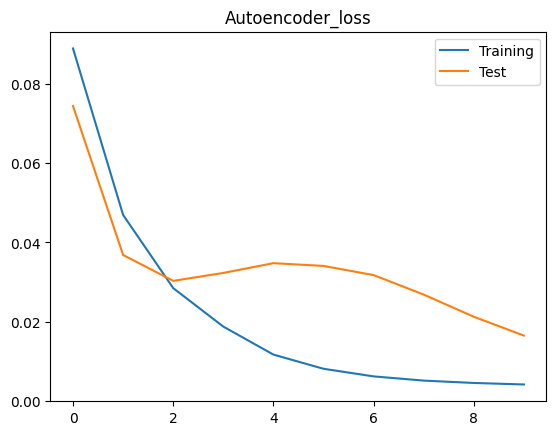

In [35]:
plt.plot(ae_history.history['loss'],label='Training')
plt.plot(ae_history.history['val_loss'],label='Test')
plt.title('Autoencoder_loss')
plt.legend()
plt.show()

In [36]:
ae_predicted=ae.predict(data_test_processed)

13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 744ms/step


In [81]:
ae_mse=mse(test_original,ae_predicted)
ae_psnr=psnr(mse(test_original,ae_predicted))
ae_ssim=ssim_mean(test_original,ae_predicted)
print('MSE:',round(ae_mse,3))
print('PSNR:',round(ae_psnr,3))
print('SSIM:',round(ae_ssim,3))

MSE: 0.03
PSNR: 63.342
SSIM: 0.107


### U-Net

In [ ]:
#U-Net for denoising images
#DoubleConv 1Conv + 1BatchNorm + 1Conv + 1BatchNorm
def unet_double_conv(filters):
    def apply(x):
        x=layers.Conv2D(filters, (3,3),padding='same',activation='relu')(x)
        x=layers.BatchNormalization()(x)
        x=layers.Conv2D(filters, (3,3),padding='same',activation='relu')(x)
        x=layers.BatchNormalization()(x)
        return x
    return apply

In [ ]:
#U-Net encoder 1MaxPooling + 1DoubleConv
def unet_encoder(filters):
    def apply(x):
        x=layers.MaxPooling2D((2,2))(x)
        x=unet_double_conv(filters)(x)
        return x
    return apply

In [ ]:
#U-Net decoder 1ConvTrans + 1Concatenate +1DoubleConv
def unet_decoder(filters):
    def apply(x, skip):
        x=layers.Conv2DTranspose(filters,(3,3),activation='relu',strides=2,padding='same')(x)
        x=layers.Concatenate()([x, skip])
        x=unet_double_conv(filters)(x)
        return x
    return apply

In [ ]:
#U-Net from 3 to 1024 with MaxPooling
def unet(input_shape=(128, 128, 3)):
    input = layers.Input(shape=input_shape)
    #Encoder from 3 to 1024
    x1 = unet_double_conv(64)(input)
    x2 = unet_encoder(128)(x1)
    x3 = unet_encoder(256)(x2)
    x4 = unet_encoder(512)(x3)
    x  = unet_encoder(1024)(x4)
    #Decoder feom 512 to 3
    x = unet_decoder(512)(x, x4)
    x = unet_decoder(256)(x, x3)
    x = unet_decoder(128)(x, x2)
    x = unet_decoder(64)(x, x1)
    output = layers.Conv2D(3,(1,1),activation='sigmoid')(x)
    return models.Model(input,output)

In [ ]:
unet=unet()
unet.summary()

In [ ]:
#Compile the unet with adam and mse
unet.compile(optimizer='adam',loss='mse')

In [ ]:
#fit unet with train and validation sets
unet_history=unet.fit(data_train_processed,epochs=20,validation_data=data_validation_processed)

In [ ]:
#Predict a single test
unet_predicted=unet.predict(single_test_original)

In [ ]:
#Check the first results of the model
fig,ax=plt.subplots(1,3)
fig.set_size_inches(10.5, 7.5)
ax[0].imshow(single_test_original[0])
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(unet_predicted[0])
ax[1].set_title('Denoised')
ax[1].axis('off')
ax[2].imshow(single_test_noise[0])
ax[2].set_title('Noised')
ax[2].axis('off')

In [ ]:
plt.plot(unet_history.history['loss'],label='Training')
plt.plot(unet_history.history['val_loss'],label='Test')
plt.title('U-Net_loss')
plt.legend()
plt.show()

In [ ]:
unet_predicted=unet.predict(data_test_processed)

In [ ]:
unet_mse=mse(test_original,unet_predicted)
unet_psnr=psnr(mse(test_original,unet_predicted))
unet_ssim=ssim_mean(test_original,ae_predicted)
print('MSE:',round(unet_mse,3))
print('PSNR:',round(unet_psnr,3))
print('SSIM:',round(unet_ssim,3))

### U-Net (Upsampling)

In [ ]:
#U-Net with updampling for denoising images
#DoubleConv 1Conv + 1BatchNorm + 1Conv + 1BatchNorm
def unet2_conv(filters):
    def apply(x):
        x = layers.Conv2D(filters, (3,3), padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(filters, (3,3), padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        return x
    return apply

In [ ]:
#Unet encoder with 1MaxPoolin and +1DoubleConv
def unet2_encoder(filters):
    def apply(x):
        x = layers.MaxPooling2D((2,2))(x)
        x = unet2_conv(filters)(x)
        return x
    return apply

In [ ]:
#Unet decoder with 1Upsampling + 1ConvTrans +1Concat + 1DoubleConv
def unet2_decoder(filters):
    def apply(x, skip):
        x = layers.UpSampling2D((2,2))(x)
        x = layers.Conv2DTranspose(filters, (1,1), activation='relu')(x)
        x = layers.Concatenate()([x, skip])
        x = unet2_conv(filters)(x)
        return x
    return apply

In [ ]:
#U-Net from 3 to 1024 with Upsampling
def unet2(input_shape=(128, 128, 3)):
    inputs = layers.Input(shape=input_shape)
    #Encoder from 3 to 1024
    x1 = unet2_conv(64)(inputs)
    x2 = unet2_encoder(128)(x1)
    x3 = unet2_encoder(256)(x2)
    x4 = unet2_encoder(512)(x3)
    x  = unet2_encoder(1024)(x4)
    #Decoder from 512 to 3
    x = unet2_decoder(512)(x, x4)
    x = unet2_decoder(256)(x, x3)
    x = unet2_decoder(128)(x, x2)
    x = unet2_decoder(64)(x, x1)
    outputs = layers.Conv2D(3, (1,1), activation='sigmoid')(x)
    return models.Model(inputs, outputs)

In [ ]:
#U-Net with Upsampling model with summary
unet2 = unet2()
unet2.summary()

In [ ]:
#U-Net with upsampling compile with adam and mse
unet2.compile(optimizer='adam',loss='mse')

In [ ]:
unet2_history=unet2.fit(data_train_processed,epochs=20,validation_data=data_validation_processed)

In [ ]:
single_unet2_predicted=unet2.predict(single_test_original)

In [ ]:
fig,ax=plt.subplots(1,3)
fig.set_size_inches(10.5, 7.5)
ax[0].imshow(single_test_original[0])
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(single_unet2_predicted[0])
ax[1].set_title('Denoised')
ax[1].axis('off')
ax[2].imshow(single_test_noise[0])
ax[2].set_title('Noised')
ax[2].axis('off')

In [ ]:
plt.plot(unet2_history.history['loss'],label='Training')
plt.plot(unet2_history.history['val_loss'],label='Test')
plt.title('U-Net2_loss')
plt.legend()
plt.show()

In [ ]:
unet2_predicted=unet2.predict(data_test_processed)

In [ ]:
unet2_mse=mse(test_original,unet2_predicted)
unet2_psnr=psnr(mse(test_original,unet2_predicted))
unet2_ssim=ssim_mean(test_original,ae_predicted)
print('MSE:',round(unet2_mse,3))
print('PSNR:',round(unet2_psnr,3))
print('SSIM:',round(unet2_ssim,3))